# Cross Entropy Method: a Minimal Example

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import CEM, utils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)

**CEM is an abstract class, so first we implement a realization of it for the private case of one-dimensional Beta distribution** (note that this specific example is already implemented within the module, and is repeated here for the demonstration):

In [2]:
from scipy import stats

class CEM_Beta(CEM.CEM):
    '''Implementation example of the CEM for a 1D Beta distribution.'''

    # Note: in this 1D case, dist is a scalar in [0,1], corresponding to the distribution mean.
    #  In general, dist may be any object that represents a distribution (e.g., any kind of array).

    def __init__(self, *args, **kwargs):
        super(CEM_Beta, self).__init__(*args, **kwargs)
        # Optional variables specifying the names of the distribution parameters and the samples
        #  in the summarizing tables. In our case, both are one-dimensional. If they were
        #  multi-dimensional, we should have provided lists of names instead of strings.
        self.default_dist_titles = 'beta_mean'
        self.default_samp_titles = 'sample'

    def do_sample(self, dist):
        return np.random.beta(2*dist, 2-2*dist)

    def pdf(self, x, dist):
        # we clip for numerical stability
        return stats.beta.pdf(np.clip(x,0.001,0.999), 2*dist, 2-2*dist)

    def update_sample_distribution(self, samples, weights):
        w = np.array(weights)
        s = np.array(samples)
        return np.clip(np.mean(w*s)/np.mean(w), 0.001, 0.999)

**Now we begin with $Beta(1, 1)$, which is simply the uniform distribution $U(0,1)$, and we aim to sample examples from the bottom 10% of that distribution.**

We use the following configuration for the CEM (which is slightly different from the default parameters):

In [3]:
n_steps = 10

# The mean of the original Beta distribution.
average = 0.5

# Every step, draw 1000 samples before updating the sample distribution.
batch_size = 1000

# When weighing the samples according to the ratio P(x; original_distribution)/P(x; sample_distribution),
#  do not clip the weights. Clipping helps for stability, but here we want a "purer" probabilistic example.
w_clip = 0

# Every update, take the bottom 50% of the samples; unless they are already below the 10% quantile
#  of the (estimated) original distribution, in which case take all samples below the 10% quantile.
internal_alpha = 0.5
ref_alpha=0.1

# In this example, we the drawn samples are themselves the scores we sort by. In general, the samples
#  would be the input configuration for some random process (e.g., the configuration of an environment
#  in RL), and the scores would be the output (e.g., the RL episode return).
#  Since the random process may evolve in time (e.g., the agent changes during the training), we need
#  to continuously re-evaluate the distribution P(x; agent, original_env_distribution) (even though
#  in this example there is no agent).
#  So every batch, we draw 20% of the samples from the original environment distribution as a reference.
ref_mode = 'train'  # use original-distribution reference from the same batch used for training
n_orig_per_batch = 0.2  # take 20% of the batch

The simulation and sampling:

In [4]:
%%time
ce = CEM_Beta(dist=average, batch_size=batch_size, w_clip=w_clip, internal_alpha=internal_alpha,
                 ref_alpha=ref_alpha, ref_mode=ref_mode, n_orig_per_batch=n_orig_per_batch)

# Simulate process & sampling
mean_ref_score_per_batch = []
mean_samp_score_per_batch = []
for batch in range(n_steps):
    for iter in range(batch_size):
        x, _ = ce.sample()
        # For this demonstration, we consider x as both sampled configuration
        #  and resulted score (no actual environment and agent...).
        score = x
        ce.update(score)

CPU times: user 2.18 s, sys: 20.2 ms, total: 2.2 s
Wall time: 2.19 s


**Evidently, the CE sampler quickly converges into the desired bottom-10% distribution (whose mean is 0.05),
whereas the reference original-distribution samples keep the original mean of 0.5:**

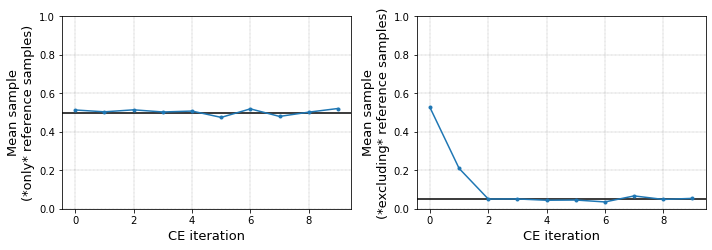

In [5]:
# Show batch scores

# Note:
# 1. ce.scores[-1] is the new empty batch that was not used yet, so we drop it.
# 2. We distinguish between original-distribution reference scores and sample-distribution scores.
mean_ref_score_per_batch = [np.mean(s[:ce.n_orig_per_batch]) for s in ce.scores[:-1]]
mean_samp_score_per_batch = [np.mean(s[ce.n_orig_per_batch:]) for s in ce.scores[:-1]]

axs = utils.Axes(2, 2)

axs[0].axhline(0.5, color='k')
axs[0].plot(np.arange(n_steps), mean_ref_score_per_batch, '.-')
axs[0].set_ylim((0,1))
axs.labs(0, 'CE iteration', 'Mean sample\n(*only* reference samples)')

axs[1].axhline(0.05, color='k')
axs[1].plot(np.arange(n_steps), mean_samp_score_per_batch, '.-')
axs[1].set_ylim((0,1))
axs.labs(1, 'CE iteration', 'Mean sample\n(*excluding* reference samples)')

plt.tight_layout()

This can also be displayed using the built-in method below - **the sample and reference distributions yield very similar statistics (mean and CVaR) in the beginning, but the sample mean quickly coincides with the reference CVaR**:

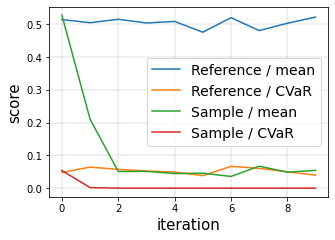

In [6]:
ce.show_sampled_scores();

**The CE class can also provide a summary of the process in both batch-level and sample-level:**

In [7]:
d1, d2 = ce.get_data()

Batch level:

In [8]:
d1

,title,batch,ref_quantile,internal_quantile,n_update_samples,update_samples_perc,beta_mean
0,CEM,0,0.098361,0.441239,400,40.0,0.500000
1,CEM,1,0.106638,0.105265,401,40.1,0.218920
2,CEM,2,0.117410,0.000534,721,72.1,0.051907
3,CEM,3,0.103456,0.000319,703,70.3,0.050720
4,CEM,4,0.103325,0.000380,721,72.1,0.049118
5,CEM,5,0.077047,0.000217,711,71.1,0.044668
6,CEM,6,0.119335,0.000020,749,74.9,0.034937
7,CEM,7,0.110856,0.001550,681,68.1,0.060678
8,CEM,8,0.101908,0.000366,717,71.7,0.051267
9,CEM,9,0.080714,0.000289,686,68.6,0.051634


Sample level:

(note again the in our simple example, the score simply equals the corresponding sample, rather than being generated by some random process that depends on that sample)

In [9]:
d2

,title,batch,sample_id,selected,weight,score,sample
0,CEM,0,0,0.0,1.000000,7.996797e-01,7.996797e-01
1,CEM,0,1,0.0,1.000000,7.952654e-01,7.952654e-01
2,CEM,0,2,0.0,1.000000,6.119513e-01,6.119513e-01
3,CEM,0,3,0.0,1.000000,5.596926e-01,5.596926e-01
4,CEM,0,4,0.0,1.000000,8.872297e-01,8.872297e-01
...,...,...,...,...,...,...,...
9995,CEM,9,995,0.0,4.475808,3.189289e-01,3.189289e-01
9996,CEM,9,996,1.0,0.018052,1.320328e-06,1.320328e-06
9997,CEM,9,997,1.0,0.018052,1.301442e-07,1.301442e-07
9998,CEM,9,998,0.0,169.530521,9.642286e-01,9.642286e-01
